In [1]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile
import matplotlib.pyplot as plt
import pickle
import PIL
from PIL import Image
from math import exp, tanh
from tokenize import Exponent
from enum import Enum
from io import BytesIO, StringIO
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from datetime import date
from io import BytesIO
from IPython import display
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
import base64
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid

<ipython-input-1-3e2e44e1ac76>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [ ]:

#https://drive.google.com/file/d/1GOKZ4vVdsHnGy8yZUXGbz-7-1zGgx4e4/view?usp=share_link

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir content
!mkdir content/FNA
!unzip drive/MyDrive/FNA.zip -d content/FNA/
#delete test data
#delete benign
!rm content/FNA/benign/10000.png
!rm content/FNA/benign/10001.png
#delete malignant
!rm content/FNA/malignant/10104.png
!rm content/FNA/malignant/10105.png

Mounted at /content/drive
Archive:  drive/MyDrive/FNA.zip
   creating: content/FNA/benign/
  inflating: content/FNA/benign/10000.png  
  inflating: content/FNA/benign/10001.png  
  inflating: content/FNA/benign/10002.png  
  inflating: content/FNA/benign/10003.png  
  inflating: content/FNA/benign/10004.png  
  inflating: content/FNA/benign/10005.png  
  inflating: content/FNA/benign/10006.png  
  inflating: content/FNA/benign/10007.png  
  inflating: content/FNA/benign/10008.png  
  inflating: content/FNA/benign/10009.png  
  inflating: content/FNA/benign/10010.png  
  inflating: content/FNA/benign/10011.png  
  inflating: content/FNA/benign/10012.png  
  inflating: content/FNA/benign/10013.png  
  inflating: content/FNA/benign/10014.png  
  inflating: content/FNA/benign/10015.png  
  inflating: content/FNA/benign/10016.png  
  inflating: content/FNA/benign/10017.png  
  inflating: content/FNA/benign/10018.png  
  inflating: content/FNA/benign/10019.png  
  inflating: content/FNA/beni

In [3]:
DATADIR = "content/FNA"

In [4]:
CATEGORIES = ['normal','benign', 'malignant']

In [5]:
"""img = cv2.imread('content/FNA/benign/10002.png',1)
rows,cols,_= img.shape

for i in range(rows):
    for j in range(cols):
        k = img[i,j]
        print(k)"""

"img = cv2.imread('content/FNA/benign/10002.png',1)\nrows,cols,_= img.shape\n\nfor i in range(rows):\n    for j in range(cols):\n        k = img[i,j]\n        print(k)"

In [6]:
import pathlib
data_dir = pathlib.Path(DATADIR)

In [7]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

3013


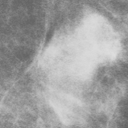

In [8]:
benign = list(data_dir.glob('benign/*'))
PIL.Image.open(str(benign[0]))

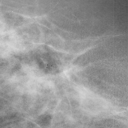

In [9]:
malignant = list(data_dir.glob('malignant/*'))
PIL.Image.open(str(malignant[0]))

In [10]:
normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[0]))
len(normal)

1015

In [11]:
batch_size = 32
img_height = 128
img_width = 128

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode='grayscale',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3013 files belonging to 3 classes.
Using 2411 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3013 files belonging to 3 classes.
Using 602 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant', 'normal']


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
      print(image_batch.shape)
      print(labels_batch.shape)
      break

(32, 128, 128, 1)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(3013).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#normalization_layer = layers.Rescaling(1./255)

In [ ]:
from pathlib import Path
import imghdr

data_dir = "oldcontent/FNA/normal/"
image_extensions = [".png"]

img_type_accepted_by_tf = ["png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
""""print(np.min(first_image), np.max(first_image))
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))"""

0.30980393 0.9607844
0.25212085 0.9291316


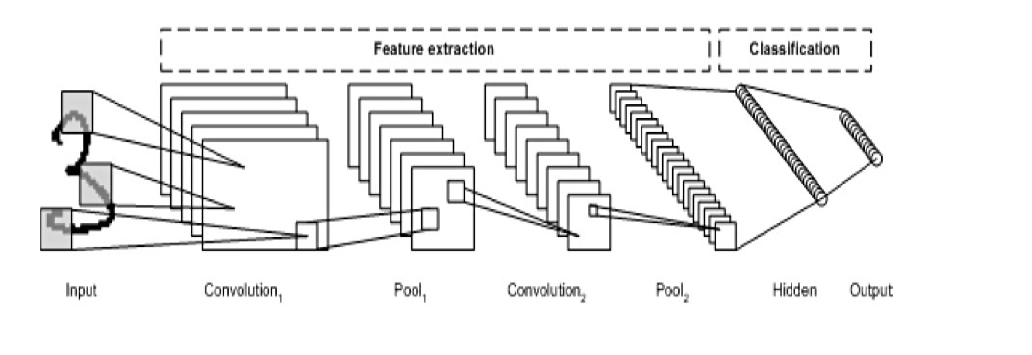

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), 
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(units=256, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


76/76 [==============================] - 50s 599ms/step - loss: 1.1012 - accuracy: 0.3629 - val_loss: 1.0952 - val_accuracy: 0.3605
Epoch 2/10
76/76 [==============================] - 46s 602ms/step - loss: 1.0935 - accuracy: 0.3870 - val_loss: 1.0730 - val_accuracy: 0.4684
Epoch 3/10
76/76 [==============================] - 48s 630ms/step - loss: 1.0369 - accuracy: 0.4596 - val_loss: 1.0200 - val_accuracy: 0.4385
Epoch 4/10
76/76 [==============================] - 45s 587ms/step - loss: 0.9695 - accuracy: 0.5209 - val_loss: 0.9208 - val_accuracy: 0.5133
Epoch 5/10
76/76 [==============================] - 45s 587ms/step - loss: 0.9275 - accuracy: 0.5404 - val_loss: 0.8828 - val_accuracy: 0.5316
Epoch 6/10
76/76 [==============================] - 45s 586ms/step - loss: 0.8967 - accuracy: 0.5628 - val_loss: 0.8945 - val_accuracy: 0.5581
Epoch 7/10
76/76 [==============================] - 45s 587ms/step - loss: 0.8695 - accuracy: 0.5832 - val_loss: 0.8475 - val_accuracy: 0.5648
Epoch 8/10

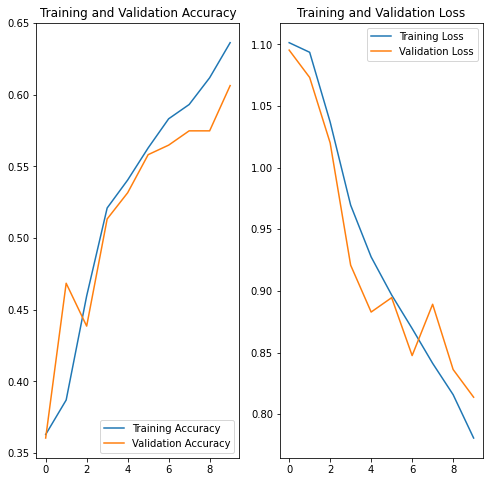

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("cnn_model-softmaxoutput.h5")

# data augmentation

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [19]:
"""for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)"""

In [20]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), 
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(units=256, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [40]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
76/76 [==============================] - 49s 649ms/step - loss: 0.8536 - accuracy: 0.5910 - val_loss: 0.8167 - val_accuracy: 0.5831
Epoch 2/20
76/76 [==============================] - 48s 634ms/step - loss: 0.8319 - accuracy: 0.6118 - val_loss: 0.8369 - val_accuracy: 0.5963
Epoch 3/20
76/76 [==============================] - 47s 615ms/step - loss: 0.8413 - accuracy: 0.5923 - val_loss: 0.7987 - val_accuracy: 0.6246
Epoch 4/20
76/76 [==============================] - 47s 619ms/step - loss: 0.8437 - accuracy: 0.5985 - val_loss: 0.7928 - val_accuracy: 0.6163
Epoch 5/20
76/76 [==============================] - 47s 618ms/step - loss: 0.8315 - accuracy: 0.6022 - val_loss: 0.7936 - val_accuracy: 0.6163
Epoch 6/20
76/76 [==============================] - 47s 617ms/step - loss: 0.8311 - accuracy: 0.6047 - val_loss: 0.7830 - val_accuracy: 0.6096
Epoch 7/20
76/76 [==============================] - 47s 617ms/step - loss: 0.8125 - accuracy: 0.6039 - val_loss: 0.7763 - val_accuracy: 0.6146

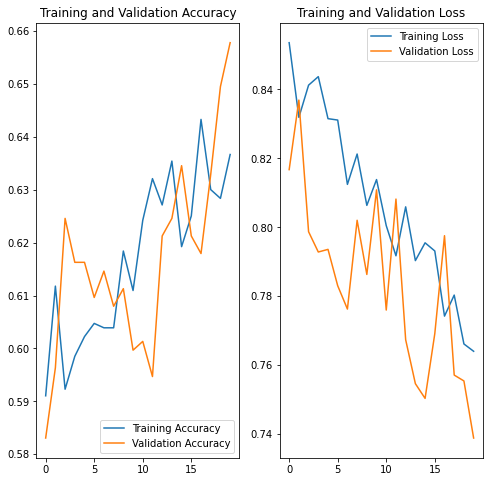

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

19/19 [==============================] - 4s 192ms/step
602
602


/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

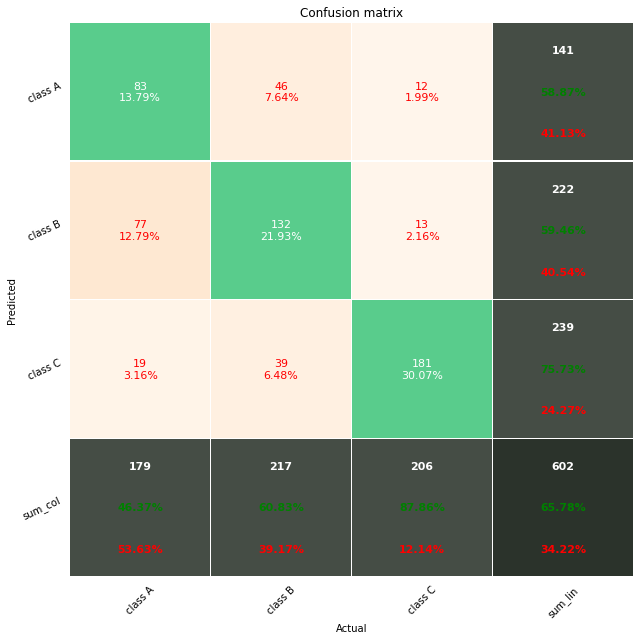

In [42]:
test_steps_per_epoch = np.math.ceil(602/32)
predictions = model.predict(val_ds, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

true_values = []

print(len(predicted_classes))
for _, labels in val_ds.take(602):
   for i in labels.numpy():
     true_values.append(i)
exact_values = np.array(true_values)
print(len(true_values))
#!pip install pretty-confusion-matrix
from pretty_confusion_matrix import pp_matrix_from_data
cmap='PuRd'
pp_matrix_from_data(exact_values,predicted_classes)

In [43]:
model.save("cnn_model-softmaxoutput.h5")

In [58]:
DATADIR = "drive/MyDrive/test_ds/ben/10000.png"
data_dir = pathlib.Path(DATADIR)

In [59]:
img = tf.keras.utils.load_img(
    data_dir, target_size=(img_height, img_width),color_mode="grayscale"
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 25ms/step
This image most likely belongs to malignant with a 46.23 percent confidence.
